# Dataset Spam 2000

In [1]:
import pandas as pd

In [3]:
df = pd.read_excel('../data/spam_v4_train.xlsx', engine='openpyxl')
df = df.iloc[0:7046]
df

,label,text
0,HAM,daerah depok enten razia mboten nggih?
1,HAM,titip adol\njual bekas mobil mobilan\napa adan...
2,HAM,Brngkali mnemukan dompet warna MARON berisi KT...
3,HAM,PT. Woneel Midas Leathers Gunungkidul Terbakar...
4,HAM,"*""Undangan Pengajian Senin Sore dan Buka Puasa..."
...,...,...
7041,HAM,WTS 2 tiket imax demon slayer jumat 15 ags. Ma...
7042,HAM,@pawnpetrol hati2 klitih
7043,HAM,@sayangkamoeeee Coba kalo berani senggol PSHT ...
7044,HAM,@ninemoirai Gapapa cuti selama nya urusan mace...


## Re-train Model

In [4]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/Users/adsdigitalpartner/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/adsdigitalpartner/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df['label'] = df['label'].str.lower()
df['label'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)
df

,label,text
0,0,daerah depok enten razia mboten nggih?
1,0,titip adol\njual bekas mobil mobilan\napa adan...
2,0,Brngkali mnemukan dompet warna MARON berisi KT...
3,0,PT. Woneel Midas Leathers Gunungkidul Terbakar...
4,0,"*""Undangan Pengajian Senin Sore dan Buka Puasa..."
...,...,...
7041,0,WTS 2 tiket imax demon slayer jumat 15 ags. Ma...
7042,0,@pawnpetrol hati2 klitih
7043,0,@sayangkamoeeee Coba kalo berani senggol PSHT ...
7044,0,@ninemoirai Gapapa cuti selama nya urusan mace...


In [6]:
df['label'].value_counts()

label
0    5049
1    1997
Name: count, dtype: int64

In [26]:
tokenizer = AutoTokenizer.from_pretrained("../models/v3-tuned")
model = AutoModelForSequenceClassification.from_pretrained("../models/v3-tuned")

In [27]:
# Preprocessing - Tokenize the email messages
def tokenize_function(text):
    # Fungsi untuk men-tokenisasi teks email dan mengubahnya menjadi input untuk model
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

In [28]:
# Tokenizing email texts
texts = list(df['text'])  # Mengambil semua teks dari kolom 'text'
labels = list(df['label'])  # Mengambil semua label (0 atau 1)
tokenized_texts = [tokenize_function(text) for text in texts]  # Tokenisasi semua teks

In [29]:
# Prepare input tensors for PyTorch
# Menggabungkan token input dan attention mask menjadi tensor yang siap digunakan untuk training
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(labels)

In [30]:
# Membagi dataset menjadi data training dan data validasi (80% training, 20% testing)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2)

In [31]:
# Membuat DataLoader untuk mini-batch training dan validation
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_inputs, val_masks, val_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [32]:
# Training setup
from torch.optim import AdamW

# Optimizer digunakan untuk mengupdate parameter model selama training
optimizer = AdamW(model.parameters(), lr=2e-5)

In [33]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
else:
	print("CUDA is not available. PyTorch is running on CPU.")

False
0
CUDA is not available. PyTorch is running on CPU.


In [34]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()

    total_loss = 0

    # Tambahkan tqdm untuk loop training
    train_loop = tqdm(train_dataloader, desc="Training", leave=False)

    for batch in train_loop:
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Update progress bar dengan current loss
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    true_labels_list = []

    val_loop = tqdm(validation_dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_loop:
            batch_input_ids, batch_attention_mask, batch_labels = batch
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            predictions_list.extend(predictions.tolist())
            true_labels_list.extend(batch_labels.tolist())

            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Epoch 1/3


Average training loss: 0.0839


Validation Accuracy: 97.02%

Epoch 2/3


Average training loss: 0.0362


Validation Accuracy: 97.87%

Epoch 3/3


Average training loss: 0.0287


Validation Accuracy: 96.81%


Confusion Matrix:
[[1006   27]
 [  18  359]]


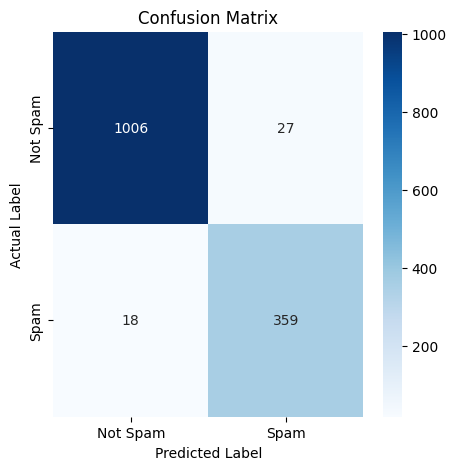

In [35]:
# Confusion Matrix & Evaluation Metrics
cm = confusion_matrix(true_labels_list, predictions_list)
print(f"Confusion Matrix:\n{cm}")

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Generate and print the classification report
classification_rep = classification_report(true_labels_list, predictions_list, target_names=['not spam', 'spam'])
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

    not spam       0.98      0.97      0.98      1033
        spam       0.93      0.95      0.94       377

    accuracy                           0.97      1410
   macro avg       0.96      0.96      0.96      1410
weighted avg       0.97      0.97      0.97      1410



In [37]:
# Save model

model.save_pretrained("../models/v3-tuned")
tokenizer.save_pretrained("../models/v3-tuned")

('../models/v3-tuned/tokenizer_config.json',
 '../models/v3-tuned/special_tokens_map.json',
 '../models/v3-tuned/vocab.txt',
 '../models/v3-tuned/added_tokens.json',
 '../models/v3-tuned/tokenizer.json')

In [38]:
tokenizer = AutoTokenizer.from_pretrained("../models/v3-tuned")
model = AutoModelForSequenceClassification.from_pretrained("../models/v3-tuned")

In [39]:
# Define a function
def predict_spam(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    predicted_label = torch.argmax(probs, dim=1).item()
    label_map = {0: "HAM", 1: "SPAM"}
    confidence = probs[0][predicted_label].item()
    return label_map[predicted_label], confidence

In [40]:
# Teks input
input_text = "�� 🔥 PSN 100 Deal �� #EAFC26 #EAFC 100€ PSN für nur 80,64€ ��19,36€ geschenkt �� https://t.co/ilhqQHizDy* 🔑Code: FORAUM8JUL Besten Preis wählen und mit SEPA zahlen #deal_bot #Guthaben #Rabatt #PSN #FIFA"

# Tokenisasi
tokenized = tokenizer(
    input_text,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt",
)

# Cara 1: Lihat tokens (teks yang dipotong-potong)
print("=== TOKENS (Teks yang Dipotong) ===")
tokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"][0])
print("Tokens:", tokens[:20])  # Tampilkan 20 pertama

# Cara 2: Lihat teks lengkap yang sudah di-decode
print("\n=== TEKS LENGKAP ===")
decoded_text = tokenizer.decode(tokenized["input_ids"][0])
print("Decoded Text:", decoded_text)

# Cara 3: Prediksi dengan hasil yang mudah dibaca
print("\n=== PREDIKSI ===")
with torch.no_grad():
    outputs = model(**tokenized)
    probs = torch.softmax(outputs.logits, dim=1)
    predicted_label = torch.argmax(probs, dim=1).item()
    confidence = probs[0][predicted_label].item()

label_map = {0: "HAM", 1: "SPAM"}
print(f"Hasil: {label_map[predicted_label]}")
print(f"Kepercayaan: {confidence:.2%}")

=== TOKENS (Teks yang Dipotong) ===
Tokens: ['[CLS]', '[UNK]', 'ps', '##n', '100', 'deal', '#', 'ea', '##fc', '##26', '#', 'ea', '##fc', '[UNK]', 'ps', '##n', 'fur', 'nur', '80', ',']

=== TEKS LENGKAP ===
Decoded Text: [CLS] [UNK] psn 100 deal # eafc26 # eafc [UNK] psn fur nur 80, [UNK] 19, [UNK] geschenkt https : / / t. co / ilhqqhizdy * [UNK] : foraum8jul besten preis wahlen und mit sepa zahlen # deal _ bot # guthaben # rabatt # psn # fifa [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

=== PREDIKSI ===
Hasil: SPAM
Kepercayaan: 99.98%


In [41]:
# Percobaan prediksi apakah pesan adalah spam atau bukan
input_text = 'Senin, 21 Juli 2025, Samapta Polsek Ngaglik melaksanakan patroli stasioner balong jalan palagan donoharjo serta antisipasi gangguan Kamtibmas, Curat, Curas, Curan dan kejahatan jalanan di wilayah Ngaglik. https://t.co/TyIvxehCV9'
print(predict_spam(input_text, model, tokenizer))

('HAM', 0.9998252987861633)


In [42]:
input_text = 'lacak hp hilang by no hp / imei lacak penipu/scammer/tabrak lari/terror/revengeporn sadap / hack / pulihkan akun #zonauang #zonauang?'
print(predict_spam(input_text, model, tokenizer))

('SPAM', 0.9997041821479797)


In [43]:
input_text = '2 Terdakwa Kasus Pemerasan Ponpes di Kota Batu Mulai Jalani Sidang https://t.co/rn6IDzYcFD'
print(predict_spam(input_text, model, tokenizer))

('HAM', 0.9998051524162292)


# Predict Batch

In [44]:
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ====== CONFIG ======
LABEL_NAMES = ["HAM", "SPAM"]  # urutan sesuai encoding model
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== LOAD DATA EXCEL ======
df_test = pd.read_excel("../data/spam_v4_train.xlsx")  

# Ambil baris 7045 sampai 11045
df_test = df_test.iloc[7045:11045].reset_index(drop=True)

texts = df_test["text"].tolist()

# ====== TOKENISASI ======
encodings = tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

dataset = torch.utils.data.TensorDataset(
    encodings["input_ids"],
    encodings["attention_mask"]
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

# ====== PREDIKSI ======
model = model.to(device)
model.eval()
predictions_all = []
confidences_all = []

with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()
        preds = probs.argmax(axis=-1)
        
        predictions_all.extend(preds)
        confidences_all.extend(probs.max(axis=-1))

# ====== SIMPAN HASIL ======
pred_labels_str = [LABEL_NAMES[p] for p in predictions_all]
df_test["predicted_label"] = pred_labels_str
df_test["confidence"] = confidences_all

df_test.to_excel("../data/hasil_prediksi_spam.xlsx", index=False)
print("\nHasil prediksi disimpan ke '../data/hasil_prediksi_spam.xlsx'")



Hasil prediksi disimpan ke '../data/hasil_prediksi_spam.xlsx'
